# Entrenamiento Clasificador de Especies de Arboles

En general en esta demostración se trabaja con rutas de archivos locales, no olvidar remplazar las rutas con sus archivos correspondientes en caso de querer ejecutar este código.

Este Notebook busca representar los pasos necesarios para poder realizar un entrenamiento exitoso de una RNN clasificadora de imágenes, utilizando el frame work PyTorch. En concreto se trabaja con un modelo `resnet18` pero es posible trabajar de la misma forma con modelos como resnet34 34 y 152, así como también otro tipo de modelos (si se consideran sus parámetros). 

**POR MEJORAR:** Como se puede ver más adelante el modelo entrenado no es infalible, presentando una proporción considerable de falsos positivos y falsos negativos. Es por esto que se presenta este cuaderno para documentar el proceso pero con un espacio para mejorar modificando parámetros o trabajando con un mejor arreglo de datos.

In [21]:
# Comenzamos importando algunas dependencias básicas
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [22]:
# Limpiar la memoria de la GPU antes e empezar (opcional pero recomendado)
torch.cuda.empty_cache()

### Paso 1: Cargar nuestro Dataset

Para comenzar el proceso de entrenamiento de nuestro modelo es necesario contar con un dataset ordenado separando las carpetas de entrenamiento, validación y testeo en una proporción definida. En concreto en este notebook se trabaja con el dataset entregado por `arbotag_api_dataset.ipynb` disponible en este mismo repositorio.

Para cargar el dataset se debe especificar la ruta en la que se encuentran nuestros archivos en `data_dir`. Al trabajar con torch y en general al entrenar en cualquier framework de RNNs es necesario comenzar definiendo un objecto que se hará cargo de cargar los datos con los que trabajaremos `dataloader`. Junto con esto se definen las transformaciones que se aplicaran a los datos. Como mínimo ya por estandar al trabajar con modelos de clasificación es necesario aplicar un re-escalamiento, convertir los datos de matrices a tensores, y normalizar los datos para trabajar todos dentro de la misma escala. Junto a esto como se puede ver en  `data_transforms` podemos definir algunas transformaciones para realizar data augmentation sobre los datos. 

Considerando que los datos elegidos para este ejemplo son arboles con fondo que normalmente se encuentran al centro de nuestra imagen se decidió agregar un recorte aleatorio sobre la imagen pero que incluya como mínimo el 80% de la imagen. 


In [23]:

data_dir = 'C:\\Users\\jflir\\Documents\\Arbocensus\\ArbocensusData\\images\\20240723_25_arbocensus_dataset_gender'

im = 540 #image side length
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((im,im)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop((im, im), scale=(0.8, 1.0), ratio=(0.9, 1.1), interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((im, im)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((im, im)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                            data_transforms[x])
                    for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
                                            shuffle=True, num_workers=3)
                for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

### Paso 2: Definir nuestro Modelo, Criterio y Optimizador

Al definir nuestro modelo se nos da la posibilidad de comenzar desde una red vacía o con pesos pre-entrenados y realizar transfer learning. Para este caso se considero mejor trabajar con una red limpia dada la especificidad de los datos. En caso de querer trabajar con un modelo pre-entrenado se debe considerar las dimensiones de las imágenes con las que se entreno en el pre-procesamiento. Si se llama a `pretrained=True` se debe considerar el modelo base que fue entrenado con imágenes de 224x224px.

Lo ideal al trabajar en local es usar una gpu para acelerar el proceso de entrenamiento, además de definir un `batch_size` que haga buen uso de la VRAM y no se sobrepase, de esta manera aseguramos un entrenamiento más eficiente. Para configurar la gpu para que sea compatible con la librería Pytorch revisar [la documentación](https://pytorch.org/get-started/locally/).

In [24]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

c:\Users\jflir\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jflir\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=0.0001)
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

### Paso 3: Definir el flujo de entrenamiento

In [26]:
def train_model(model, criterion, optimizer, num_epochs=30, patience=5, min_delta=0):
    since = time.time()  # Registrar el tiempo de inicio

    for epoch in range(num_epochs):
        epoch_start = time.time()  # Registrar el tiempo de inicio de la época
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        losses = []

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Poner el modelo en modo de entrenamiento
            else:
                model.eval()   # Poner el modelo en modo de evaluación

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    losses.append(loss.item())
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        epoch_time = time.time() - epoch_start  # Calcular el tiempo de la época
        print('Epoch complete in {:.0f}m {:.0f}s'.format(
            epoch_time // 60, epoch_time % 60))  # Imprimir el tiempo transcurrido
        print()

    total_time = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        total_time // 60, total_time % 60))  # Imprimir el tiempo total

    return model


### Paso 4: Entrenar y guardar los pesos resultantes

In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=60, patience=5, min_delta=0.01)

Epoch 0/59
----------
train Loss: 1.6730 Acc: 0.4158
val Loss: 1.7474 Acc: 0.4376
Epoch complete in 2m 3s

Epoch 1/59
----------
train Loss: 1.5276 Acc: 0.4423
val Loss: 1.5497 Acc: 0.4360
Epoch complete in 2m 2s

Epoch 2/59
----------
train Loss: 1.4394 Acc: 0.4712
val Loss: 1.5917 Acc: 0.4231
Epoch complete in 2m 2s

Epoch 3/59
----------
train Loss: 1.3715 Acc: 0.4999
val Loss: 1.4146 Acc: 0.4773
Epoch complete in 2m 3s

Epoch 4/59
----------
train Loss: 1.3093 Acc: 0.5197
val Loss: 1.5187 Acc: 0.4675
Epoch complete in 2m 2s

Epoch 5/59
----------
train Loss: 1.2517 Acc: 0.5406
val Loss: 1.2563 Acc: 0.5459
Epoch complete in 2m 3s

Epoch 6/59
----------
train Loss: 1.1940 Acc: 0.5665
val Loss: 1.3745 Acc: 0.5010
Epoch complete in 2m 3s

Epoch 7/59
----------
train Loss: 1.1509 Acc: 0.5810
val Loss: 1.3336 Acc: 0.5175
Epoch complete in 2m 3s

Epoch 8/59
----------
train Loss: 1.1173 Acc: 0.5928
val Loss: 1.2342 Acc: 0.5501
Epoch complete in 2m 2s

Epoch 9/59
----------
train Loss: 1.0

In [30]:
torch.save(model_ft.state_dict(), 'resnet18.pth')

### Paso 5: Medir el rendimiento del modelo entrenado

c:\Users\jflir\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jflir\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\jflir\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Predicted class: No Especificado


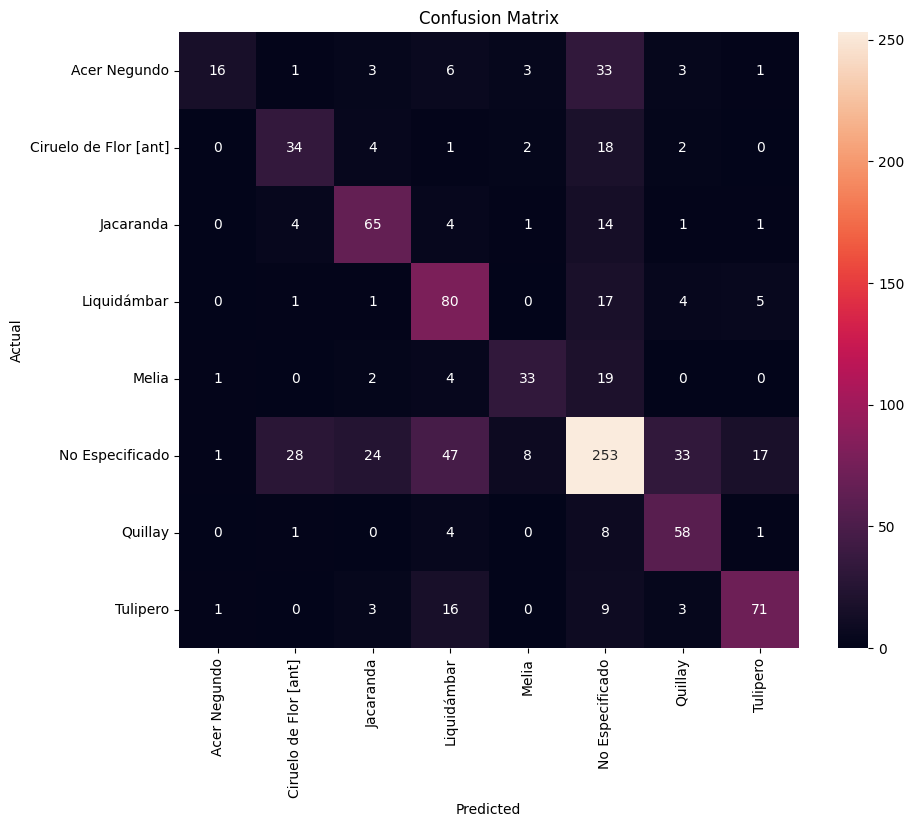

In [32]:
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model.load_state_dict(torch.load('resnet18.pth'))
model = model.to(device)
model.eval()

test_image = dataloaders['test'].dataset[0][0].unsqueeze(0).to(device)

# Function to evaluate a single image
def evaluate_image(model, test_image):
    with torch.no_grad():
        outputs = model(test_image)
        _, predicted = torch.max(outputs, 1)
        class_idx = predicted.item()
    return class_idx

# Function to plot confusion matrix
def plot_confusion_matrix(model, dataloader, class_names):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate a sample image
test_image = dataloaders['test'].dataset[0][0].unsqueeze(0).to(device)
predicted_class_idx = evaluate_image(model, test_image)
predicted_class_label = dataloaders['test'].dataset.classes[predicted_class_idx]
print(f'Predicted class: {predicted_class_label}')

# Plot confusion matrix
plot_confusion_matrix(model, dataloaders['test'], dataloaders['test'].dataset.classes)
    